In [1]:
# python stdlib
import time
t1 = time.time()
import os
from itertools import product

# Scientific python libraries
import numpy as np
import scipy as sp
import scipy.integrate as spyint
from numba import njit
import sympy as sm
from scipy.constants import e, k, h
from scipy.interpolate import interp1d

from scipy.optimize import minimize, basinhopping
from scipy.stats import linregress

# Visualization
import matplotlib.pyplot as plt
import matplotlib.transforms

DELTA = 0.250*1e-3*e
ROK_ENERGY_UNIT = (DELTA/0.166)
DELTA_UNIT = ROK_ENERGY_UNIT
V_RANGE = 0.605
FREQUENCY = 2*np.pi*368*1e6

In [2]:
UDIRS = [float(x[2:]) for x in os.listdir('NRG/') if x[0]=='U']
GAMDIRS = {x:[float(x1[6:]) for x1 in os.listdir(f'NRG/U={x}') if x1[0]=='G'] for x in UDIRS}
GAMDIRS

{0.333: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.01125],
 0.416: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0075]}

In [3]:
GRAND_DICT = dict()
for UVALS in UDIRS:
    GAMMA_DICT = dict()
    for GAMMA_VALS in GAMDIRS[UVALS]:
        PATHSTR = f'NRG\\U={UVALS}\\Gamma={GAMMA_VALS}\\'
        FILE_NAMES = [x[3:] for x in os.listdir(PATHSTR) if x[0]=='g']
        GAMMA_DICT[GAMMA_VALS] = FILE_NAMES
    GRAND_DICT[UVALS] = GAMMA_DICT

In [4]:
def nrg_data_func(u, gammat, gap):
    pathstr = f"NRG/U={u}/Gamma={gammat}/gap{gap}/"
    op = np.genfromtxt(pathstr + "optical1.dat")
    n1 = np.genfromtxt(pathstr + "n1.dat")
    n2 = np.genfromtxt(pathstr + "n2.dat")
    return op, n1, n2

In [5]:

def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator


def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator


def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator


def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator


def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dne - dng) - dne)


def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator


def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)


def conductance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [6]:

def analytical_data(gammat, gap, log_g0, global_parameters, v0):
    u, alpha, temp, log_n = global_parameters
    
    v0 = v0*alpha
    normunit = ROK_ENERGY_UNIT*1e3/e
    nu = (1 - v0/(u*normunit))
    
    n = 10**log_n
    g0 = 10**log_g0
    
    delta = DELTA_UNIT*np.float64(gap)
    
    if log_g0 == 0.0: g0 = 0.0
    w = FREQUENCY
    
    gamma_t_values = np.array(GAMDIRS[u])
    
    
    gammat_approx = gamma_t_values[np.argmin((gamma_t_values - gammat)**2)]
    
    o1, n1, n2 = nrg_data_func(u,gammat_approx,gap)
    
    s_mg = np.interp(nu, o1[:,0], o1[:, 1])*delta
    n_g  = np.interp(nu, n1[:,0], n1[:, 1])
    n_e  = np.interp(nu, n2[:,0], n2[:, 1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:, 1] - n1[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_e = np.interp(nu, n2[1:,0], (n2[1:, 1] - n2[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    ds_mg = np.interp(nu, o1[1:, 0], (o1[1:, 1] - o1[:-1, 1]) / (-0.01*u)) * delta / ROK_ENERGY_UNIT
    
    q_caps = alpha*alpha*q_capacitance(s_mg, temp, n, dn_e, dn_g)*1e15
    t_caps = alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e15
    t_caps = (t_caps + t_caps[::-1])/2
    c_total = q_caps + t_caps
    
    couduc = alpha*alpha*conductance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e8
    couduc = (couduc + couduc[::-1])/2
    
    return q_caps, c_total, couduc

In [7]:
# nrg_data_func(0.416, 0.01, '0.0165999999999997')
# nrg_data_func(0.416, 0.03, '0.0598521511727022')
# NRG/U=0.416/Gamma=0.01/gap/optical1.dat
# analytical_data(GAMMA_T[0], '0.0165999999999997', LN_GAMMA_0[0], GLOBALS_P, np.array([0]))

In [8]:
EXPERIMENTAL_PATH = "G:/My Drive/GROWTH/Quantum computing/Majorana Project/Experimental data/data-oct4-21-mail-filip/data/"
openbx = np.array([x[18:-4] for x in os.listdir(EXPERIMENTAL_PATH) if x[-1]=='v' and x[11]=='c'])
closebx = np.array([x[16:-4] for x in os.listdir(EXPERIMENTAL_PATH) if x[-1]=='v' and x[11]=='o'])

closebx = np.array(np.sort(np.int32(closebx)), dtype=np.unicode_)
closebx[0] = '00'

openbx = np.array(np.sort(np.int32(openbx)), dtype=np.unicode_)
openbx[0] = '00'


# EXPERIMENTAL_DATA_C = np.array([np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_closed_{data_set}.csv",
#                                          skiprows = 1,
#                                          delimiter = ',')[:, [0, 1, 5]] for data_set in closebx])
# EXPERIMENTAL_DATA_O = np.array([np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_open_{data_set}.csv",
#                                          skiprows = 1,
#                                          delimiter = ',')[:, [0, 1, 5]] for data_set in openbx])

def dataset_func_O(Bfield):
    return np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_open_{Bfield}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]

def dataset_func_C(Bfield):
    return np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_closed_{Bfield}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]

In [9]:
# V_RANGE = 0.60

def experimental_data(Bfield,symmetrize): #filter
    exp_v, exp_c, exp_r = dataset_func_C(Bfield).T
    exp_g = 1/exp_r
    exp_v = exp_v*1e3
#     print(np.min(exp_v))
    filter_bool = (exp_v < V_RANGE) * (-V_RANGE < exp_v) #+ True
    
    exp_c = exp_c[filter_bool]*1e15
    exp_g = exp_g[filter_bool]*1e8
    exp_v = exp_v[filter_bool]
    
    if symmetrize:
        exp_c = (exp_c + exp_c[::-1])/2
        exp_g = (exp_g + exp_g[::-1])/2
        
    return exp_v, exp_c, exp_g


In [10]:
# fixed = U, alpha, T, N
# global = gamma_t, Gamma_0
# local = Delta

In [11]:
def simple_cost(fixed, gamma_t, Gamma_0, Delta, Bfieldv):
    exp_v, exp_c, _ = experimental_data(Bfieldv,0)
    cap_thresh = 0.027
    q_caps = analytical_data(gamma_t, Delta, Gamma_0, fixed, exp_v)[1]
    weight = ((q_caps - exp_c)**2) / (np.maximum(cap_thresh, (q_caps + exp_c)/2)**2) * (1 - np.abs(exp_v)/V_RANGE)
    return np.sum(weight)

In [12]:
def min_delta(fixed, gamma_t, Gamma_0, Bfieldv):
    gapvalues = GRAND_DICT[fixed[0]][gamma_t]
    cost_vals = np.array([simple_cost(fixed, gamma_t, Gamma_0, Delta_vals, Bfieldv) 
                 for Delta_vals in 
                 gapvalues
                ])
    min_cost_idx = np.argmin(cost_vals)
    return gapvalues[min_cost_idx], cost_vals[min_cost_idx]

In [13]:
def sum_wight(fixed, gamma_t, Gamma_0):
    gap_costs = np.array([min_delta(fixed, gamma_t, Gamma_0, Bfieldvals) for Bfieldvals in closebx])
    return gap_costs[:,0], np.sum(np.float64(gap_costs[:,1]))

In [14]:
#u3 vals
parampath = "G:\My Drive\GROWTH\Quantum computing\Majorana Project\parameter_NewData_delta-0.25_binmin_u3.csv"
PARAMETERS = np.loadtxt(parampath, skiprows = 1, delimiter = ',')
GLOBALS_P = PARAMETERS[0,3:]

GAMMA_T_U3 = 0.01125

Gapvalues_opt = sum_wight(GLOBALS_P,GAMMA_T_U3,4)
Gapvalues_opt

C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return g0*numerator/denominator
C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:30: RuntimeWarning: invalid value encountered in multiply
  numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gamma(g0, smg, T, N)
C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:40: RuntimeWarning: invalid value encountered in multiply
  numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:20: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(smg/(k*T))
C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:21: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(smg/(k*T)) + N
C:\Users\rupes\AppData\Local\Temp\ipykernel_17580\3752456116.py:22: RuntimeWarning: invalid value encountered in tr

(array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], dtype='<U32'),
 nan)

In [15]:
#u4 vals
parampath = "G:\My Drive\GROWTH\Quantum computing\Majorana Project\parameter_NewData_delta-0.25_binmin_u4.csv"
PARAMETERS = np.loadtxt(parampath, skiprows = 1, delimiter = ',')
GLOBALS_P = PARAMETERS[0,3:]

GAMMA_T_U4 = 0.01125

Gapvalues_opt = sum_wight(GLOBALS_P, GAMMA_T_U4, 4)
Gapvalues_opt

KeyError: 0.01125

In [29]:
def min_gammat(fixed, Gamma_0):
    
    gammavals = list(GRAND_DICT[fixed[0]].keys())
    cost_vals = np.array([sum_wight(fixed, gammats, Gamma_0)[1] for gammats in gammavals])
    min_cost_idx = np.argmin(cost_vals)
    return gammavals[min_cost_idx], cost_vals[min_cost_idx]

In [30]:
def optimize_function(Gamma_0,fixed):
    return min_gammat(fixed, Gamma_0)[1]

In [18]:
%%time
optimize_function(4, GLOBALS_P)

CPU times: total: 1min 57s
Wall time: 3min 46s


471.43312272012486

In [31]:
def minimize_dissipation(global_values):
    inital_x = (6.0)

    result = basinhopping(optimize_function,
                          inital_x,
                          niter=30,
                          minimizer_kwargs={'args':global_values,"method": 'trust-constr'},
#                           T=10,
#                           stepsize=2
                         )
    result = result.lowest_optimization_result
    return_set = [result.success]
    if result.success:
        return_set.append(result.fun)
        return_set.append((*global_values, *result.x))
    return return_set


In [34]:
from scipy.optimize import minimize

In [35]:
GLOBALS_P

array([0.333     , 0.63382225, 0.06963484, 9.65529677])

In [37]:
%%time
opt_result = minimize(optimize_function,2.0,args=GLOBALS_P)
opt_result
# 0.92946468

CPU times: total: 29min 40s
Wall time: 55min 42s


      fun: 471.31430731174646
 hess_inv: array([[95228.04186603]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 8
     njev: 13
   status: 0
  success: True
        x: array([-0.29779294])

In [38]:
optimize_function(0.0, GLOBALS_P)

471.31430727784453

In [39]:
min_gammat(GLOBALS_P, 0.0)

(0.01, 471.31430727784453)

In [40]:
ares = sum_wight(GLOBALS_P, 0.01, 0.0)
ares

(array(['0.163491039509815', '0.145664408830709', '0.160084602632483',
        '0.163491039509815', '0.163491039509815', '0.15660408679214',
        '0.15660408679214', '0.1494', '0.1494', '0.13788995612444',
        '0.133833478621756', '0.120849824162057', '0.11135618527949',
        '0.1162', '0.11135618527949', '0.11135618527949',
        '0.11135618527949', '0.120849824162057', '0.106291862341385',
        '0.0953597399325313', '0.10097385800295', '0.11135618527949',
        '0.106291862341385'], dtype='<U32'),
 471.31430727784453)

In [71]:
def plotfunc(fixed, gamma_t, Gamma_0, Deltas, save=False):
    plt.close('all')
    fig, axes = plt.subplots(5,5,figsize=(25,20))
    axes = axes.flatten()
    u, alpha, temp, log_n = fixed
    parameter_string1 = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} * 1.506 meV $\
            $log_{{10}} N   = {log_n:.3f}$"
#     parameter_string2 = f"$log_{{10}} \Gamma_0 / Hz = {float(Gamma_0):.3f} $\
#             $\Gamma_t        = {gamma_t} $"
    parameter_string2 = f"$\Gamma_t        = {gamma_t} $"
    fig.text(
        0.5, 0.95, parameter_string1, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.92, parameter_string2, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='lemonchiffon'), fontsize=20)
    
    for ax, delta, Bfieldvals in zip(axes,Deltas,closebx):
        exp_v, exp_c, _ = experimental_data(Bfieldvals,0)
        q_caps = analytical_data(gamma_t, delta, Gamma_0, fixed, exp_v)[1]
        ax.plot(exp_v, q_caps, label=f'Delta = {float(delta):.3f} meV')
        ax.plot(exp_v, exp_c, label=f'B = {Bfieldvals} mT')
#         ax.legend(bbox_to_anchor=(0.1, -0.03, 0.8, .102),ncol=1)
        ax.legend(bbox_to_anchor=(0., 0.9, 1, .2),ncol=2)
#         ax.set_ylim(0,None)
    fig.delaxes(axes[-1])
    fig.delaxes(axes[-2])
    axes[0].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[5].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[10].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[15].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[20].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[22].set_xlabel(r'$V_{P0} (mV) $',fontsize=15)

    
    if save:
        plt.savefig(f'DeltaDependenceFit_v2u{u}.pdf')
#     axes

In [40]:
def theoDelta(B):
    return 0.25*np.sqrt(1 - (B/220)**2)

In [54]:
Δ=Δ0 sqrt(1 - (B/Bc)^2)

array([0.25      , 0.2497416 , 0.2489648 , 0.24766471, 0.24583304,
       0.24345779, 0.24052285, 0.23700743, 0.23288524, 0.22812341,
       0.22268089, 0.21650635, 0.2095351 , 0.20168454, 0.1928473 ,
       0.18288042, 0.17158715, 0.15868455, 0.14373989, 0.12602882,
       0.10414945, 0.07451635, 0.        ])

In [109]:
Gapvalues_opt[0].shape

(23,)

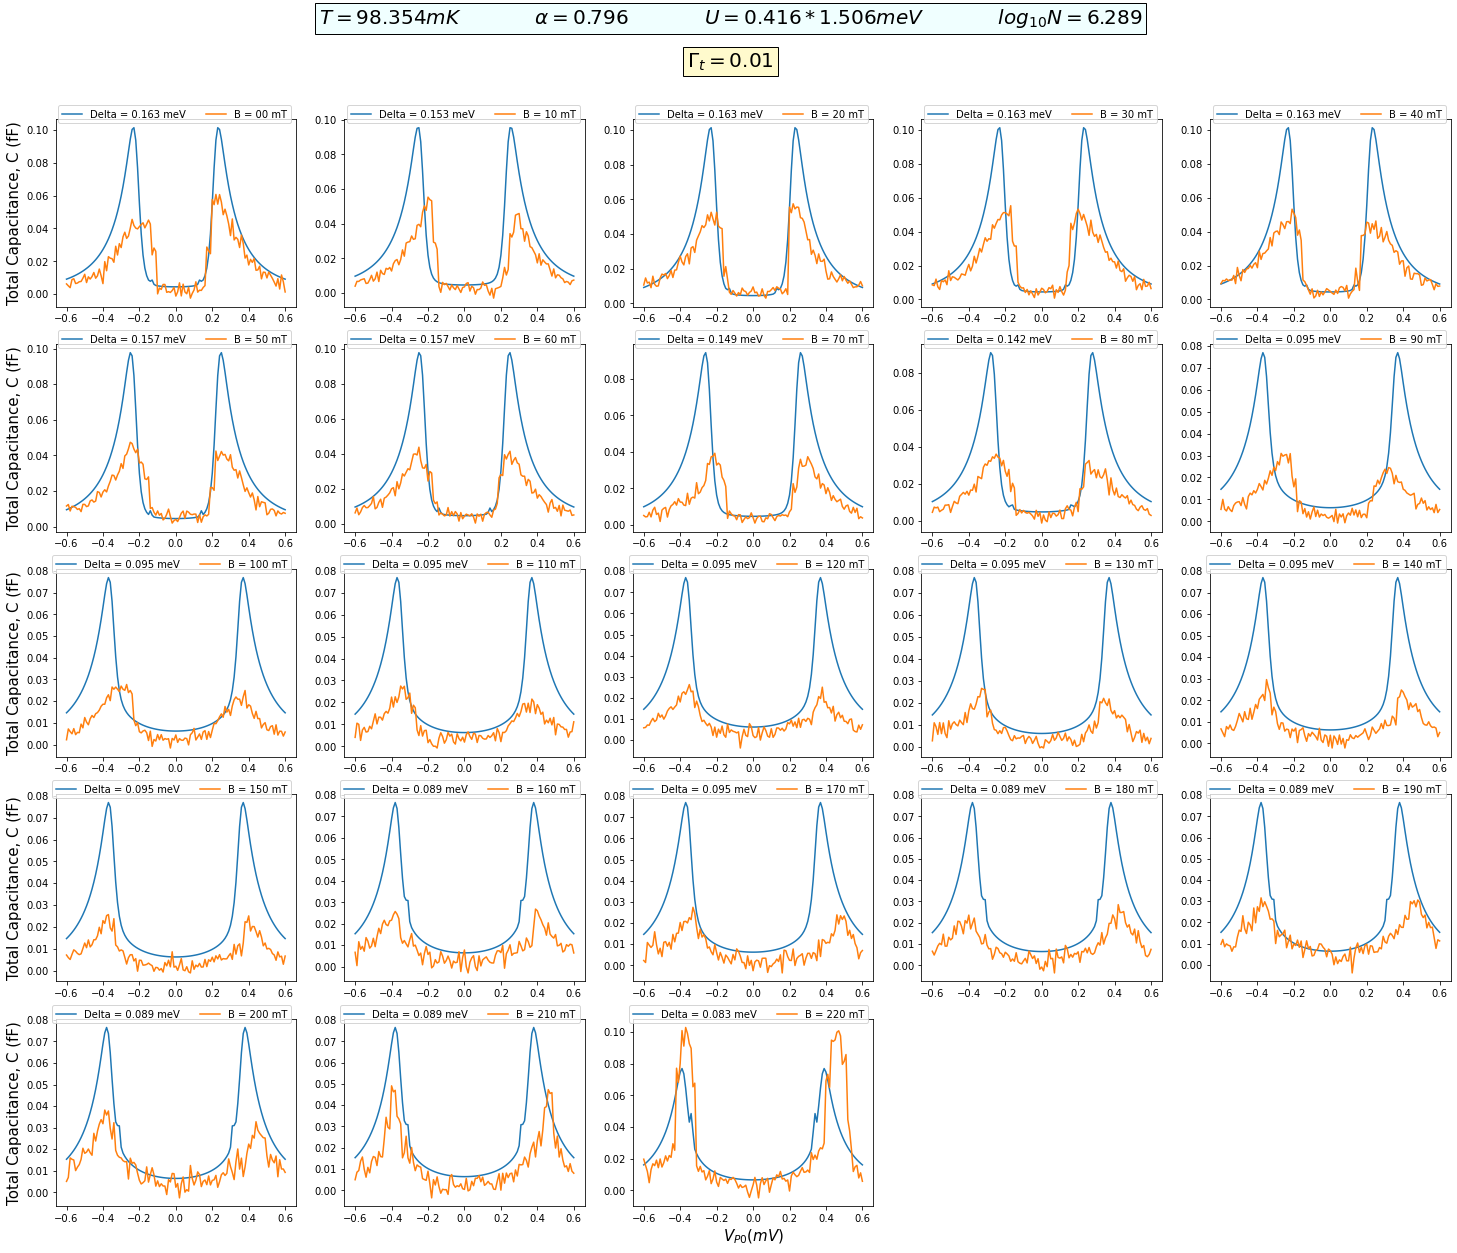

In [111]:
plotfunc(GLOBALS_P, 0.01, 0.0,Gapvalues_opt[0],False)

In [105]:
def DeltaB(fixed, gamma_t, Gamma_0, Deltas, save=False):
    plt.close()
    fig, axis = plt.subplots(1,1,figsize=(7,7))
    
#     slope, intercept, _, _, _ = linregress(np.float64(closebx), np.float64(Deltas)*DELTA_UNIT*1e3/e)
    
#     Bfiled_range = np.linspace(np.min(np.float64(closebx)), np.max(np.float64(closebx)), 100)
#     axis.plot(Bfiled_range, slope*Bfiled_range + intercept, 'k')
#     axis.text(0.5, 0.8, f'Slope = {slope:.3e}\nIntercept = {intercept:.3f}', transform=axis.transAxes, fontsize=15)

    axis.scatter(np.float64(closebx), theoDelta(np.float64(closebx)),label='$\Delta = \Delta_0 \sqrt{1 - (B/B_c)^2}$')
    axis.scatter(np.float64(closebx), np.float64(Deltas)*DELTA_UNIT*1e3/e, 10, 'red',label='Fit')
    axis.legend()

    axis.set_xlabel('Magnetic Field, $B$ (mT)',fontsize=13)
    axis.set_ylabel('Gap, $\Delta$ (meV)',fontsize=13)
    axis.set_title('Gap, $\Delta$ vs Magnetic Field, $B$',fontsize=13,y=0.99)
    
    u, alpha, temp, log_n = fixed
    parameter_string1 = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} * 1.506 meV $\
            $log_{{10}} N   = {log_n:.3f}$"
#     parameter_string2 = f"$log_{{10}} \Gamma_0 / Hz = {float(Gamma_0):.3f} $\
#             $\Gamma_t        = {gamma_t} $"
    parameter_string2 = f"$\Gamma_t        = {gamma_t} $"
    fig.text(
        0.5, 0.98, parameter_string1, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
    fig.text(
        0.5, 0.93, parameter_string2, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='lemonchiffon'), fontsize=10)
    
    if save:
        plt.savefig(f"DeltaFit_vs_B_v3{u}.pdf", format='pdf')


In [108]:
Gapvalues_opt[0]

array(['0.163491039509815', '0.153044437991062', '0.163491039509815',
       '0.163491039509815', '0.163491039509815', '0.15660408679214',
       '0.15660408679214', '0.1494', '0.141830462172271',
       '0.0953597399325313', '0.0953597399325313', '0.0953597399325313',
       '0.0953597399325313', '0.0953597399325313', '0.0953597399325313',
       '0.0953597399325313', '0.0893937357984328', '0.0953597399325313',
       '0.0893937357984328', '0.0893937357984328', '0.0893937357984328',
       '0.0893937357984328', '0.083'], dtype='<U32')

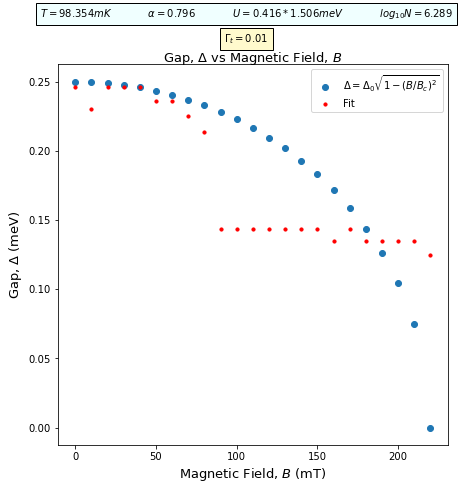

In [106]:
DeltaB(GLOBALS_P, 0.01, 0.0,Gapvalues_opt[0],True)

In [30]:
# v, c, _ = experimental_data(closebx[0],1)
# print(min_delta(GLOBALS_P, 0.01, 4, closebx[0]))
# _, c_total, _ = analytical_data(0.01, min_delta(GLOBALS_P, 0.01, 4, closebx[0])[0], 4, GLOBALS_P, v)
# plt.plot(v,c)
# plt.plot(v,c_total)


In [31]:
# def delta_plot(gammat, log_g0, global_parameters, v0, param_idx, save=False):
    
#     u, alpha, temp, log_n = global_parameters
    
#     gamma_t_values = np.array(GAMDIRS[u])
#     gammat_approx = gamma_t_values[np.argmin((gamma_t_values - gammat[param_idx])**2)]
#     print('error % = ', np.round(np.abs(gammat_approx - gammat[param_idx])/np.abs(gammat[param_idx]), 2))
    
#     matrixx = np.array([
#              analytical_data(gammat_approx,
#                              gapvals,
#                              log_g0[param_idx],
#                              global_parameters,
#                              v0
#                             )[1:]
#              for gapvals in GRAND_DICT[0.416][gammat_approx]
#          ])
    
    
#     y1max = np.max(matrixx[:,0,:])
#     y1min = np.min(matrixx[:,0,:])
#     y2max = np.max(matrixx[:,1,:])
#     y2min = np.min(matrixx[:,1,:])
#     s1 = y1max - y1min
#     s2 = y2max - y2min
#     plt.close('all')
#     fig, ax = plt.subplots(1,2,figsize=(15,15))
# #     plt.suptitle(f'$\Gamma_t$ = {gammat_approx}')

#     parameter_string = f"$T = {temp*1000:.3f} mK $\
#       $\\alpha        = {alpha:.3f} $\
#       $U       = {u:.3f} meV $\
#       $log_{{10}} N   = {log_n:.3f}$\
#       $\Gamma_t = {gammat_approx:.3f}$\
#       $log \Gamma_0 = {log_g0[param_idx]:.3f}$"
#     fig.text(
#         0.51, 0.92, parameter_string, ha='center', va='center', wrap=False,
#         bbox=dict(ec='black', alpha=1, color='azure'), fontsize=15)
    
#     for idx, rows in enumerate(matrixx):
#         xvals = v0
#         y1vals = rows[0,:]
#         y2vals = rows[1,:]
#         ax[0].plot(xvals, idx+(y1vals/s1))
#         ax[1].plot(xvals, idx+(y2vals/s2))
#     ax[0].set_title('Capacitance, C',fontsize=15)
#     ax[0].set_ylim(-1,26)
#     ax[0].set_yticks([],[])
#     ax2 = ax[0].twinx()
#     ax2.set_ylim(-1,26)
#     ax2.yaxis.set_ticks_position('right')
#     ax2.set_yticks(np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,0],labels=[], fontsize = 12)
    
#     ax[1].set_title('Conductance, G',fontsize=15)
#     ax[0].set_ylabel('Gap, $\Delta$ (meV)',fontsize=15)
#     ax[0].set_xlabel('$V_{P0} (mV) $',fontsize=17)
#     ax[1].set_xlabel('$V_{P0} (mV) $',fontsize=17)
#     ax[1].set_yticks(*np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,:].T, fontsize = 12)
#     ax[1].set_ylim(-1,26)
#     ax[1].tick_params(axis='x', which='major', labelsize=12)
#     ax[0].tick_params(axis='x', which='major', labelsize=12)
#     ax[0].text(-0.2,25.2, f'Scale = {s1*1e-15:.2e} F',fontsize=12)
#     ax[1].text(-0.2,25.2, f'Scale = {s2*1e-8:.2e} S',fontsize=12)

# #     plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45) 

#     # Create offset transform by 5 points in x direction
#     dx = -0.2; dy = 0.0
#     offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

#     # apply offset transform to all x ticklabels.
#     for label in ax[1].yaxis.get_majorticklabels():
#         label.set_transform(label.get_transform() + offset)
#     if save:
#         plt.savefig(f'Delta Dependence idx{param_idx}.pdf',metadata = {'Author': 'R K Rupesh', 'Title': f'Gamma_t 0.03 idx{param_idx}'})
#     return fig
# fig = delta_plot(GAMMA_T, LN_GAMMA_0, GLOBALS_P, np.arange(-V_RANGE,V_RANGE,0.01), 10, save=False)

In [32]:
# fig, ax = plt.subplots(1,2,figsize=(15,15))
# matrix_e = np.array([experimental_data(Bfieldvals,0) for Bfieldvals in closebx])
# y1max = np.max(matrix_e[:-2,1,:])
# y1min = np.min(matrix_e[:-2,1,:])
# y2max = np.max(matrix_e[:-2,2,:])
# y2min = np.min(matrix_e[:-2,2,:])
# s1 = (y1max - y1min) #*0 + 1
# s2 = (y2max - y2min) #*0 + 1

# for idx, rows in enumerate(matrix_e[::-1,:,:]):
#     if idx in [0,1]:
#         continue
#     xvals = rows[0,:]
#     y1vals = rows[1,:]
#     y2vals = rows[2,:]
    
# #     y1max = np.max(rows[1,:])
# #     y1min = np.min(rows[1,:])
# #     y2max = np.max(rows[2,:])
# #     y2min = np.min(rows[2,:])
# #     s1 = (y1max - y1min) #*0 + 1
# #     s2 = (y2max - y2min) #*0 + 1
    
#     ax[0].plot(xvals, idx+(y1vals/s1))
#     ax[1].plot(xvals, idx+(y2vals/s2))

# ax[1].set_title('Conductance, G',fontsize=15)
# ax[0].set_ylabel('B field (mT)',fontsize=15)
# ax[0].set_xlabel('$V_{P0} (mV) $',fontsize=17)
# ax[1].set_xlabel('$V_{P0} (mV) $',fontsize=17)
# ax[0].set_title('Capacitance, C',fontsize=15)

# ax[0].set_yticks([],[])
# ax2 = ax[0].twinx()
# ax2.set_ylim(1,25)
# ax[0].set_ylim(1,25)
# ax[1].set_ylim(1,25)
# ax2.yaxis.set_ticks_position('right')
# ax[1].set_yticks(*np.array(list(enumerate(np.float64(closebx[::-1]))))[2::2,:].T, fontsize = 12)
# ax2.set_yticks(np.array(list(enumerate(np.float64(closebx[::-1]))))[2::2,0], labels=[], fontsize = 12)

# ax[1].tick_params(axis='x', which='major', labelsize=12)
# ax[0].tick_params(axis='x', which='major', labelsize=12)
# ax[0].text(-0.2,24.2, f'Scale = {s1*1e-15:.2e} F',fontsize=12)
# ax[1].text(-0.2,24.2, f'Scale = {s2*1e-8:.2e} S',fontsize=12)

# dx = -0.2; dy = 0.0
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# # apply offset transform to all x ticklabels.
# for label in ax[1].yaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)

# plt.savefig('Experimental Data Bx Closed_2v0.pdf')

1.5060240963855422